# Project 4: Final Project - Random Acts of Pizza
### Predicting altruism through free pizza

This project is originated from the Kaggle competition https://www.kaggle.com/c/random-acts-of-pizza. We will create an algorithm to predict which requests will recieve pizza and which on will not.  The competition contains a dataset with 5671 textual requests for pizza from the Reddit community Random Acts of Pizza together with their outcome (successful/unsuccessful) and meta-data. This data was collected and graciously shared by Althoff et al (http://www.timalthoff.com/). 

**Reference Paper:**
Tim Althoff, Cristian Danescu-Niculescu-Mizil, Dan Jurafsky. How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Proceedings of ICWSM, 2014. (http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf)


## Approach 


**Step 1:  Exploratory Data Analysis **

**Step 2:  Create a Baseline Model **

**Step 3:  Feature Engineering **

- Preprocessing data 
    - data cleansing 
    - data transformation

- Use other meta-data from the data set, such as,
    - request_text_edit_aware
    - request_title
    - requester_account_age_in_days_at_request
    - requester_days_since_first_post_on_raop_at_request
    - requester_number_of_comments_at_request
    - requester_number_of_comments_in_raop_at_request
    - requester_number_of_posts_at_request
    - requester_number_of_posts_on_raop_at_request
    - requester_number_of_subreddits_at_request
    - requester_subreddits_at_request
    - requester_upvotes_minus_downvotes_at_request
    - requester_upvotes_plus_downvotes_at_request
    - requester_username
    - unix_timestamp_of_request
    - unix_timestamp_of_request_utc
    - other features includes:
        - number of requests made by the same user
        - number of requests fulfilled or % of requests fulfilled, etc
    
- Generate new features from the data set such as, 
    - Politeness, 
    - Evidentiality, 
    - Reciprocity, 
    - Sentiment, 
    - Length, etc

**Step 4:  Algorithm / Model Selection **

- Generative Models 
    - Naive Bayes 
- Discriminative Models
    - Logistic Regression  
- Neural Network 


**Step 5:  Error Analysis & Optimization ** 


**Step 6:  Final Model ** 




## Load Data

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

/Users/shanhe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shanhe/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# read json file
train_json = json.load(open('/Users/shanhe/Desktop/W207/Final Project/EDA/train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('/Users/shanhe/Desktop/W207/Final Project/EDA/test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

print("Train shape: ", train_json_df.shape)
print("Test shape: ", test_json_df.shape)

Train shape:  (4040, 32)
Test shape:  (1631, 17)


The training data has 32 columns, while the test data only has 17. __Data providers have removed fields from the test set which would not be available at the time of posting.__

In [3]:
# Create a test dataframe with only the mathcing train columns
test_w_train_col = train_json_df[test_json_df.columns.values]

In [4]:
# Check to see that dataset is balanced in number of request success and failures
print(train_json_df['requester_received_pizza'].value_counts())
print("Percentage of request failures: " + str(round(3046/len(train_json_df),2)*100)+"%.")
print("Percentage of request failures: " + str(round(994/len(train_json_df),2)*100)+"%.")

False    3046
True      994
Name: requester_received_pizza, dtype: int64
Percentage of request failures: 75.0%.
Percentage of request failures: 25.0%.


We should consider balancing our features to that it's closer to 50-50. To do this we can try duplicating our successes.

In [5]:
test_w_train_col.shape

(4040, 17)

In [6]:
# for the baseline, we just use the "request_text_edit_aware" as input features 
# but we can explore other metadata (such as "request_title", 
# "number_of_downvotes_of_request_at_retrieval", "number_of_upvotes_of_request_at_retrieval", etc) 
# to add to the input features 
# train_data = train_json_df.request_text_edit_aware.as_matrix()

# convert the requester_received_pizza field to 0 and 1
# 0 means the user doesn't receive pizza & 1 means the user receives pizza
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

# split the training data into training data and dev data 
train_data_df, dev_data_df, train_labels, dev_labels = \
            train_test_split(test_w_train_col, train_labels, test_size=0.2, random_state=42)
    
    
# apply same logic as train_data to test_data
test_data_df = test_json_df

print('training data shape:', train_data_df.shape)
print('dev data shape:', dev_data_df.shape)
print('test data shape:', test_data_df.shape)
print('training labels shape:', train_labels.shape)
print('dev labels shape:', dev_labels.shape)

training data shape: (3232, 17)
dev data shape: (808, 17)
test data shape: (1631, 17)
training labels shape: (3232,)
dev labels shape: (808,)


## Step 2: Create a Baseline Model 

In [7]:
# use standard CountVectorizer to transform the training data and dev data 
vectorizer = CountVectorizer() 
train_bag_of_words = vectorizer.fit_transform(train_data_df.request_text_edit_aware.as_matrix())
dev_bag_of_words = vectorizer.transform(dev_data_df.request_text_edit_aware.as_matrix())

# create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(nb, parameters)
    
# train the MultinomialNB
clf.fit(train_bag_of_words, train_labels)

pred_dev_prob = clf.predict_proba(dev_bag_of_words)[:,0]

print(clf.best_params_)
print("auc score using CountVectorizer & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))


{'alpha': 8.385454545454545}
auc score using CountVectorizer & MultinomialNB = 0.5880349615375456


We use the Naive Bayes model combined with a bag of words approach as our baseline since  Naive Bayes is the most straightforward modeling approach to take in terms of model assumptions (feature independence) and complexity but also tends to work well with text. Word counts are natural features for NB since we calculate probabilities from observation counts. We see with an auc of .588, our baseline does better than randomly guessing (auc of .5) but not by too much.

## Step 3: Feature Engineering

In [8]:
test_data_df.head(10)

,giver_username_if_known,request_id,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,t3_i8iy4,Hey all! It's about 95 degrees here and our ki...,[request] pregger gf 95 degree house and no fo...,42.083866,0.000000,57,0,10,0,16,"[AskReddit, COents, Denver, DenverBroncos, Lib...",364,840,j_like,1.308963e+09,1.308960e+09
1,N/A,t3_1mfqi0,I didn't know a place like this exists! \n\nI ...,"[Request] Lost my job day after labour day, st...",223.784537,0.000000,145,0,36,0,29,"[Android, AskReddit, GrandTheftAutoV, IAmA, Mi...",516,1448,0110110101101100,1.379264e+09,1.379260e+09
2,N/A,t3_lclka,Hi Reddit. Im a single dad having a really rou...,(Request) pizza for my kids please?,0.000000,0.000000,0,0,0,0,0,[],0,0,singledad22601,1.318636e+09,1.318633e+09
3,N/A,t3_1jdgdj,Hi I just moved to Waltham MA from my home sta...,[Request] Just moved to a new state(Waltham MA...,481.311273,0.000000,277,0,17,0,30,"[AdviceAnimals, Art, AskReddit, GetMotivated, ...",1058,2062,Neuronut,1.375220e+09,1.375217e+09
4,N/A,t3_t2qt4,We're just sitting here near indianapolis on o...,"[Request] Two girls in between paychecks, we'v...",0.000000,0.000000,0,0,0,0,0,[],0,0,so_damn_hungry,1.335934e+09,1.335931e+09
5,N/A,t3_pvojb,"So, I'm a student in London, and it's my birth...",[REQUEST] It's my birthday tomorrow (UK),144.875093,44.114606,418,2,117,0,41,"[Art, AskReddit, FIFA12, FantasyPL, IAmA, Life...",6331,31919,leiferic,1.329602e+09,1.329602e+09
6,N/A,t3_142n4c,"I'm not entirely sure why, I guess just kindof...","[Request] Just kindof sad/disappointed, could ...",185.766100,0.000000,2,0,2,0,3,"[Random_Acts_Of_Pizza, atheism, technology]",7,27,cafepressguy,1.354313e+09,1.354313e+09
7,N/A,t3_17rja6,I'm a visiting medical student from Costa Rica...,[Request] Visiting student could use warm food.,1198.620231,0.000000,42,0,11,0,14,"[AnimalPorn, AskReddit, Music, Random_Acts_Of_...",176,286,javilopez1,1.359832e+09,1.359832e+09
8,N/A,t3_1lg6u2,My SO and I are moving to the new apartment to...,"[Request] Pregnant, packing @ 2am to move tomo...",43.332118,0.000000,1,0,0,0,1,[IAmA],0,6,RosyGraymalkin,1.377933e+09,1.377930e+09
9,N/A,t3_1b0mtx,My partner is a wonderful gender-queer pansexu...,"[Request] My partner and I hit six-months, we ...",787.698322,0.000000,625,0,129,0,72,"[Anarchism, AnarchistNews, Anarcho_Capitalism,...",2796,5186,vomitisjustskimmilk,1.364269e+09,1.364265e+09


In [28]:
def clean_datetime (df):
    #clean up datetime
    df.loc[:,'datetime_request'] = pd.to_datetime(df.unix_timestamp_of_request.map(lambda x: format(x, 'f')), unit = 's')
    df.loc[:,'datetime_request_utc'] = pd.to_datetime(df.unix_timestamp_of_request_utc.map(lambda x: format(x, 'f')), unit = 's')
    #build local month, week, day, hour
    df.loc[:,'month_request'] = df['datetime_request'].dt.month
    df.loc[:,'week_request'] = df['datetime_request'].dt.week
    df.loc[:,'weekday_request'] = df['datetime_request'].dt.weekday
    df.loc[:,'hour_request'] = df['datetime_request'].dt.hour
    
clean_datetime(train_data_df)
clean_datetime(dev_data_df)
clean_datetime(test_json_df)

/Users/shanhe/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
train_data_df.dtypes

giver_username_if_known                                       object
request_id                                                    object
request_text_edit_aware                                       object
request_title                                                 object
requester_account_age_in_days_at_request                     float64
requester_days_since_first_post_on_raop_at_request           float64
requester_number_of_comments_at_request                        int64
requester_number_of_comments_in_raop_at_request                int64
requester_number_of_posts_at_request                           int64
requester_number_of_posts_on_raop_at_request                   int64
requester_number_of_subreddits_at_request                      int64
requester_subreddits_at_request                               object
requester_upvotes_minus_downvotes_at_request                   int64
requester_upvotes_plus_downvotes_at_request                    int64
requester_username                

In [11]:
train_data_df.columns

Index(['giver_username_if_known', 'request_id', 'request_text_edit_aware',
       'request_title', 'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc',
       'datetime_request', 'datetime_request_utc', 'month_request',
       'week_request', 'weekday_request', 'hour_request'],
      dtype='object')

In [12]:
#date time dummies, for models that need dummy variables
def dt_dummies(df):    
    week_dummies = pd.get_dummies(df['week_request'], prefix  = 'week')
    weekday_dummies = pd.get_dummies(df['weekday_request'], prefix  = 'weekday')
    hour_dummies = pd.get_dummies(df['hour_request'], prefix  = 'hour')
    
    #return merged datetime features
    return week_dummies.merge(hour_dummies.merge(weekday_dummies, left_index = True, right_index = True), left_index = True, right_index = True)

In [29]:
# use standard CountVectorizer to transform the text
vectorizer = CountVectorizer() 
train_bag_of_words = vectorizer.fit_transform(train_data_df.request_text_edit_aware)
dev_bag_of_words = vectorizer.transform(dev_data_df.request_text_edit_aware)
test_bag_of_words = vectorizer.transform(test_data_df.request_text_edit_aware)

In [14]:
# use standard CountVectorizer with defined processor to transform the text
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer

def better_preprocessor(s):
    
    #turn all characters to lowers case and tokenize all numbers to one token
    pattern = re.compile(r'\d+')

    #delete stop words
    en_stop = get_stop_words('en') #get english stopwords
    new_s = ' '.join([i for i in s.split() if not i in en_stop])
    
    #stemming
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    new_s = ' '.join([p_stemmer.stem(i) for i in new_s.split()])
    
#     #shortening long words, the choice of 6 characters came from reiteration to find the number with best performance
#     new_s = ' '.join([w[:6] if len(w) > 6 else w for w in new_s.split()])
    
    return new_s


In [18]:
train_bag_of_words.shape

(3232, 10969)

__Testing using word count + date time features__

In [19]:
from scipy import sparse

train_set = sparse.hstack((train_bag_of_words
                           , dt_dummies(train_data_df)
                          ))

dev_set = sparse.hstack((dev_bag_of_words
                         , dt_dummies(dev_data_df)
                        ))

# create MultinomialNB
nb = MultinomialNB()
    
# test the best value for alpha
parameters = {'alpha': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best alpha
clf = GridSearchCV(nb, parameters)
    
# # train the MultinomialNB
clf.fit(train_set, train_labels)

pred_dev_prob = clf.predict_proba(dev_set)[:,0]

print(clf.best_params_)
print("auc score using CountVectorizer & MultinomialNB = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))



{'alpha': 3.037272727272727}
auc score using CountVectorizer & MultinomialNB = 0.5724356379051656


In [20]:
from scipy import sparse

train_set = sparse.hstack((train_bag_of_words
                           , dt_dummies(train_data_df)
                          ))

dev_set = sparse.hstack((dev_bag_of_words
                         , dt_dummies(dev_data_df)
                        ))

# create LR 
LR_0 = LogisticRegression()
    
# test the best value for C
parameters = {'C': np.linspace(0.01, 10, 100)}

# create GridSearchCV to find the best C
clf = GridSearchCV(LR_0, parameters)
    
# # train the MultinomialNB
clf.fit(train_set, train_labels)

pred_dev_prob = clf.predict_proba(dev_set)[:,0]

print(clf.best_params_)
print("auc score using CountVectorizer & Logistic Regression = {}".format(roc_auc_score(dev_labels, pred_dev_prob, average='micro')))


{'C': 0.01}
auc score using CountVectorizer & Logistic Regression = 0.44800622385227873


In [21]:
train_data_df['request_text_edit_aware'].map(lambda x: 1 if ('please' in x.lower()) | ('thank' in x.lower()) | ('appreciate' in x.lower()) else 0)

1610    1
1941    1
3475    0
3189    1
1538    1
2903    0
3306    0
1957    0
1427    1
283     1
712     0
274     1
2293    0
621     1
1476    0
3447    0
1632    1
2880    0
3103    1
1114    1
423     0
3185    1
1108    0
506     0
1886    1
3599    0
1566    0
2533    1
500     0
2658    1
       ..
955     1
1215    0
2433    0
2853    1
3485    0
1515    1
2391    1
769     0
3380    0
1685    0
130     1
3735    0
2919    1
3171    1
3444    1
2135    1
1482    1
330     1
1238    1
466     0
2169    0
1638    1
3092    0
3772    1
1095    1
1130    1
1294    0
860     1
3507    1
3174    0
Name: request_text_edit_aware, Length: 3232, dtype: int64

__XGBoost with default request text + other features__

In [30]:
#features to be used by XGBoost
train_feature = train_data_df[[
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
#        'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'month_request',
       'week_request','weekday_request', 'hour_request']]

#add new features
train_feature['length_of_request'] = train_data_df['request_text_edit_aware'].map(lambda x: len(x))
train_feature['length_of_title'] = train_data_df['request_title'].map(lambda x: len(x))

#inspired by the paper, How to Ask for a Favor: A Case Study on the Success of Altruistic Requests, Tim Althoff et al
train_feature['first_half_of_month'] = train_data_df['datetime_request'].dt.day.map(lambda x: 1 if x <= 15 else 0)

#add feature showing gratitude
train_feature['shown_gratitude'] = train_data_df['request_text_edit_aware'].map(lambda x: 1 if ('please' in x.lower()) | ('thank' in x.lower()) | ('appreciate' in x.lower()) else 0)

#replicate for dev data
dev_feature = dev_data_df[[
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
#        'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'month_request',
       'week_request','weekday_request', 'hour_request']]

dev_feature['length_of_request'] = dev_data_df['request_text_edit_aware'].map(lambda x: len(x))
dev_feature['length_of_title'] = dev_data_df['request_title'].map(lambda x: len(x))
dev_feature['first_half_of_month'] = dev_data_df['datetime_request'].dt.day.map(lambda x: 1 if x <= 15 else 0)
dev_feature['shown_gratitude'] = dev_data_df['request_text_edit_aware'].map(lambda x: 1 if ('please' in x.lower()) | ('thank' in x.lower()) | ('appreciate' in x.lower()) else 0)

#replicate for dev data
test_feature = test_data_df[[
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
#        'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'month_request',
       'week_request','weekday_request', 'hour_request']]

test_feature['length_of_request'] = test_data_df['request_text_edit_aware'].map(lambda x: len(x))
test_feature['length_of_title'] = test_data_df['request_title'].map(lambda x: len(x))
test_feature['first_half_of_month'] = test_data_df['datetime_request'].dt.day.map(lambda x: 1 if x <= 15 else 0)
test_feature['shown_gratitude'] = test_data_df['request_text_edit_aware'].map(lambda x: 1 if ('please' in x.lower()) | ('thank' in x.lower()) | ('appreciate' in x.lower()) else 0)


/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shanhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

In [97]:
import xgboost as xgb

# create request text features
vectorizer1 = CountVectorizer(preprocessor = better_preprocessor, ngram_range=(2,2)) 
train_req_bag_of_words = vectorizer1.fit_transform(train_data_df.request_text_edit_aware)
dev_req_bag_of_words = vectorizer1.transform(dev_data_df.request_text_edit_aware)
test_req_bag_of_words = vectorizer1.transform(test_data_df.request_text_edit_aware)

# # create request text features
# vectorizer2 = CountVectorizer(preprocessor = better_preprocessor) 
# train_title_bag_of_words = vectorizer2.fit_transform(train_data_df.request_title)
# dev_title_bag_of_words = vectorizer2.transform(dev_data_df.request_title)

# #create text features
# vectorizer = TfidfVectorizer(preprocessor = better_preprocessor) 
# train_bag_of_words = vectorizer.fit_transform(train_data_df.request_text_edit_aware)
# dev_bag_of_words = vectorizer.transform(dev_data_df.request_text_edit_aware)

# train_bag_of_words.shape
#create dmatrices
dtrain = xgb.DMatrix(sparse.hstack((train_req_bag_of_words
                           , train_feature
                          )), train_labels)
ddev = xgb.DMatrix(sparse.hstack((dev_req_bag_of_words
                         , dev_feature
                        )) , dev_labels)

#booster parameter
param = {'max_depth': 7, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic'
         , 'scale_pos_weight': 1, 'colsample_bytree': 1, 'subsample': 1, 'gamma': 2}
param['nthread'] = 4
param['eval_metric'] = 'auc'

#specify validation set to watch performance
evallist = [(ddev, 'eval'), (dtrain, 'train')]

#train model
num_round = 1000
bst = xgb.train(param.items(), dtrain, num_round, evallist, early_stopping_rounds=20)


[0]	eval-auc:0.565382	train-auc:0.72686
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 20 rounds.
[1]	eval-auc:0.572122	train-auc:0.74215
[2]	eval-auc:0.592905	train-auc:0.776535
[3]	eval-auc:0.599542	train-auc:0.794781
[4]	eval-auc:0.605726	train-auc:0.795924
[5]	eval-auc:0.601685	train-auc:0.80917
[6]	eval-auc:0.614423	train-auc:0.820814
[7]	eval-auc:0.617967	train-auc:0.830472
[8]	eval-auc:0.618614	train-auc:0.834714
[9]	eval-auc:0.619904	train-auc:0.840834
[10]	eval-auc:0.620988	train-auc:0.849456
[11]	eval-auc:0.622465	train-auc:0.852811
[12]	eval-auc:0.624469	train-auc:0.856264
[13]	eval-auc:0.626196	train-auc:0.864786
[14]	eval-auc:0.625584	train-auc:0.872151
[15]	eval-auc:0.626755	train-auc:0.87848
[16]	eval-auc:0.62664	train-auc:0.886336
[17]	eval-auc:0.627934	train-auc:0.889426
[18]	eval-auc:0.632566	train-auc:0.8936
[19]	eval-auc:0.63165	train-auc:0.895277
[20]	eval-auc:0.634619	train-auc:0.

In [91]:
bst.best_iteration, bst.best_score

(126, 0.907624)

**Predict**

In [98]:
dtest = xgb.DMatrix(sparse.hstack((test_req_bag_of_words
                         , test_feature
                        )))

pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [99]:
(pred > 0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
(pred > 0.5).astype(int).sum()

102

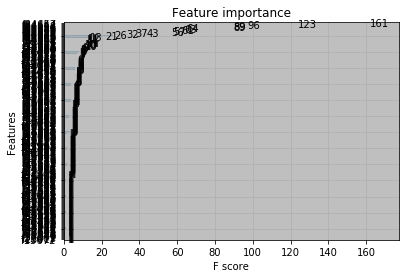

In [101]:
xgb.plot_importance(bst)

**Submission**

In [106]:
results = pd.DataFrame(np.vstack((test_data_df.request_id, (pred > 0.5).astype(int))).T)
results.columns = ["request_id", "requester_received_pizza"]
results.head(5)

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0


In [108]:
results.to_csv('Submission_0410.csv')

__LDA Topic Model__

In [26]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
texts = []

for i in train_data_df.request_text_edit_aware[:200]:
    
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
#     stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
#     texts.append(stemmed_tokens)
    texts.append(stopped_tokens)

dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

/Users/shanhe/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:497: RuntimeWarning: overflow encountered in exp
  expElogthetad = np.exp(Elogthetad)


In [27]:
ldamodel.print_topics(num_topics = 10, num_words = 10)

[(0,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadsticks" + nan*"clock" + nan*"door" + nan*"addition" + nan*"o" + nan*"16"'),
 (1,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadsticks" + nan*"clock" + nan*"door" + nan*"addition" + nan*"o" + nan*"16"'),
 (2,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadsticks" + nan*"clock" + nan*"door" + nan*"addition" + nan*"o" + nan*"16"'),
 (3,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadsticks" + nan*"clock" + nan*"door" + nan*"addition" + nan*"o" + nan*"16"'),
 (4,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadsticks" + nan*"clock" + nan*"door" + nan*"addition" + nan*"o" + nan*"16"'),
 (5,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadsticks" + nan*"clock" + nan*"door" + nan*"addition" + nan*"o" + nan*"16"'),
 (6,
  'nan*"itll" + nan*"probably" + nan*"argue" + nan*"arrive" + nan*"breadstick